In [13]:
import numpy as np
import pandas as pd
import cv2
import mediapipe as mp
import face_recognition_models
import dlib
import os
from mediapipe.python.solutions.drawing_utils import _normalized_to_pixel_coordinates
from time import time
import matplotlib.pyplot as plt
import imutils
from imutils import face_utils
import face_recognition

In [14]:
face_recognition_model = face_recognition_models.face_recognition_model_location()
face_encoder = dlib.face_recognition_model_v1(face_recognition_model)
hog_face_detector = dlib.get_frontal_face_detector()


In [15]:
landmark_points_68 = [162,234,93,58,172,136,149,148,152,377,378,365,397,288,323,454,389,71,63,105,66,107,336,
                  296,334,293,301,168,197,5,4,75,97,2,326,305,33,160,158,133,153,144,362,385,387,263,373,
                  380,61,39,37,0,267,269,291,405,314,17,84,181,78,82,13,312,308,317,14,87]
    
landmark_points_5_1 = [ 2, #bottom of nose tip
                     362, #left eye towards centre
                     263, #left eye away from centre
                     33,  #right eye away from centre
                     133 #right eye towards centre 
                    ]
landmark_points_5_2 = [ 2, #bottom of nose tip
                     263, #left eye away from centre
                     362, #left eye towards centre
                     133, #right eye towards centre 
                     33  #right eye away from centre
                    ]
landmark_points_5_3 = [ 263, #left eye away from centre
                       362, #left eye towards centre
                       33,  #right eye away from centre
                       133, #right eye towards centre
                        2 #bottom of nose tip 
                    ]

In [16]:
mp_drawing = mp.solutions.drawing_utils

mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.7)

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1,min_detection_confidence=0.5)

In [17]:
filepath="E:\\Pix\\Munmun_wedding\\DSC_0492.jpg"
sample_img = cv2.imread(filepath.replace('\\' , '/'))

In [23]:
def dlib_detection(image, hog_face_detector, display = True):

    height, width, _ = image.shape
    output_image = image.copy()
    imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    start = time()
    results = hog_face_detector(imgRGB, 0)
    end = time()

    for bbox in results:
        x1 = bbox.left()
        y1 = bbox.top()
        x2 = bbox.right()
        y2 = bbox.bottom()
        cv2.rectangle(output_image, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=width//200)  

    if display:
        cv2.putText(output_image, text='Time taken: '+str(round(end - start, 2))+' Seconds.', org=(10, height//10),
                    fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=width//700, color=(0,0,255), thickness=width//500)
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');

    else:
        return output_image, results
    
def mp_detection(face_detection,image, display = True):
    height, width, _ = image.shape
    output_image =  image.copy()
    start = time()
    results = face_detection.process( image[:,:,::-1])
    end = time()
    bbox_drawing_spec=mp_drawing.DrawingSpec(color=(255, 255, 255),thickness=30)
    keypoint_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0),thickness=50,circle_radius=1)
    if results.detections:
        for face_no, face in enumerate(results.detections):
            #mp_drawing.draw_detection(image=output_image, detection=face,bbox_drawing_spec=bbox_drawing_spec,keypoint_drawing_spec=keypoint_drawing_spec)
            mp_drawing.draw_detection(image=output_image, detection=face,bbox_drawing_spec=bbox_drawing_spec)
    if display:
        cv2.putText(output_image, text='Time taken: '+str(round(end - start, 2))+' Seconds.', org=(10, height//10),
                    fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=width//700, color=(0,0,255), thickness=width//500)
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow( image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');

    else:
        return output_image, results
    
def mp_landmark(face_mesh,image, display = True):
    height, width, _ = image.shape
    output_image =  image.copy()
    start = time()
    results = face_mesh.process( image[:,:,::-1])
    end = time()
    if results.multi_face_landmarks:
        for facial_landmarks in results.multi_face_landmarks:
            for i in landmark_points_5_3:                    ######### CORRECTION: landmark_points_5_3 is the correct one for sure
                pt1 = facial_landmarks.landmark[i]
                x = int(pt1.x * width)
                y = int(pt1.y * height)
                cv2.circle(output_image, (x, y), 30, (0, 255, 0), -1)
    if display:
        cv2.putText(output_image, text='Time taken: '+str(round(end - start, 2))+' Seconds.', org=(10, height//10),
                    fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=width//700, color=(0,0,255), thickness=width//500)
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow( image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');
    else:
        return output_image, results
    
def dlib_landmark(hog_face_detector,image, display = True):
    height, width, _ = image.shape
    predictor = dlib.shape_predictor("shape_predictor_5_face_landmarks.dat")
    gray = cv2.cvtColor(sample_img, cv2.COLOR_BGR2GRAY)
    output_image = sample_img.copy()
    # detect faces in the grayscale image
    start = time()
    results = hog_face_detector(gray, 1)
    end = time()
    # loop over the face detections
    for (i, rect) in enumerate(results):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)
        j=0
        for (x, y) in shape:
            j+=1
            cv2.circle(output_image, (x, y), 30, (0, 0, 255), -1)
            cv2.putText(output_image,str(j), (x, y),fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=width//1000, color=(0,0,255), thickness=width//1000)
            
    if display:
        cv2.putText(output_image, text='Time taken: '+str(round(end - start, 2))+' Seconds.', org=(10, height//10),
                    fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=width//700, color=(0,0,255), thickness=width//500)
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow( image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');
    else:
        return output_image, results
    
def landmark_pt_list(mesh_results,width,height):
        ## function for return 5 landmarks in a dlib usable datatype

    if mesh_results.multi_face_landmarks:
        for i,face_landmarks in enumerate(mesh_results.multi_face_landmarks): 
            if i==0:
                raw_landmark_set = []
                for index in landmark_points_5_3:                       ######### CORRECTION: landmark_points_5_3 is the correct one for sure
                    x = int(face_landmarks.landmark[index].x * width)
                    y = int(face_landmarks.landmark[index].y * height)
                    landmark_point=dlib.point([x,y])
                    raw_landmark_set.append(landmark_point)
                all_points=dlib.points(raw_landmark_set)
#         return dlib.points([{
#             "nose_tip": [raw_landmark_set[0]],
#             "left_eye": raw_landmark_set[1:3],
#             "right_eye": raw_landmark_set[3:],
#             }])
        return all_points

def mp_bounding_rect(detection_results,width,height):
        #function for returning the bounding box in a dlib usable datatype

    if detection_results.detections:
        for i,detection in enumerate(detection_results.detections):
            if i==0:
                # bbox data
                bbox = detection.location_data.relative_bounding_box
                xy_min = _normalized_to_pixel_coordinates(bbox.xmin, bbox.ymin, height,width)
                xy_max = _normalized_to_pixel_coordinates(bbox.xmin + bbox.width, bbox.ymin + bbox.height,height,width)
                if xy_min is None or xy_max is None:return
                else:
                    xmin,ymin =xy_min
                    xmax,ymax = xy_max
                    rectangle= dlib.rectangle(left=xmin, top=ymax, right=xmax, bottom=ymin)
                    return rectangle
                
def ret_encoding(filepath,num_jitters=1):
        ##function for returning the encodings

    image_input = cv2.imread(filepath)
    image_input = cv2.cvtColor(image_input, cv2.COLOR_BGR2RGB)
    #image_input =face_recognition.load_image_file(filepath)
    height,width=image_input.shape[:-1]           ######## CORRECTION : height and width interchanged
    
    mesh_results = face_mesh.process(image_input)            #### mediapipe facial landmarks
    all_points=  landmark_pt_list(mesh_results,width,height) 
    
#     detection_results = face_detection.process(image_input) ######mediapipe face detection
#     b_box=mp_bounding_rect(detection_results,width,height)

    _,detection_results=dlib_detection(image_input, hog_face_detector, display = False) ## dlib face detection
    b_box=detection_results[0]
    
    if (all_points is None) or (b_box is None):return 
    raw_landmark_set=dlib.full_object_detection(b_box,all_points)
    encodings=face_encoder.compute_face_descriptor(image_input, raw_landmark_set, num_jitters)
    return encodings

## Compare face detection ##

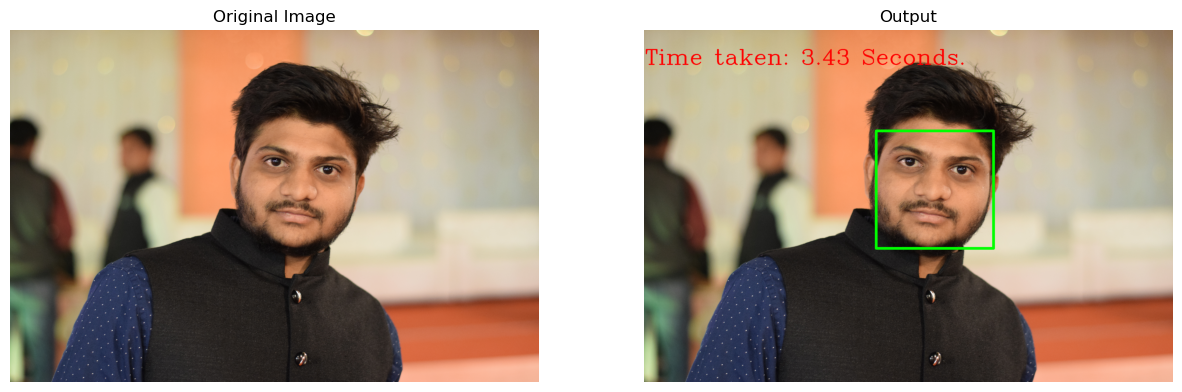

In [7]:
dlib_detection(sample_img, hog_face_detector, display=True)

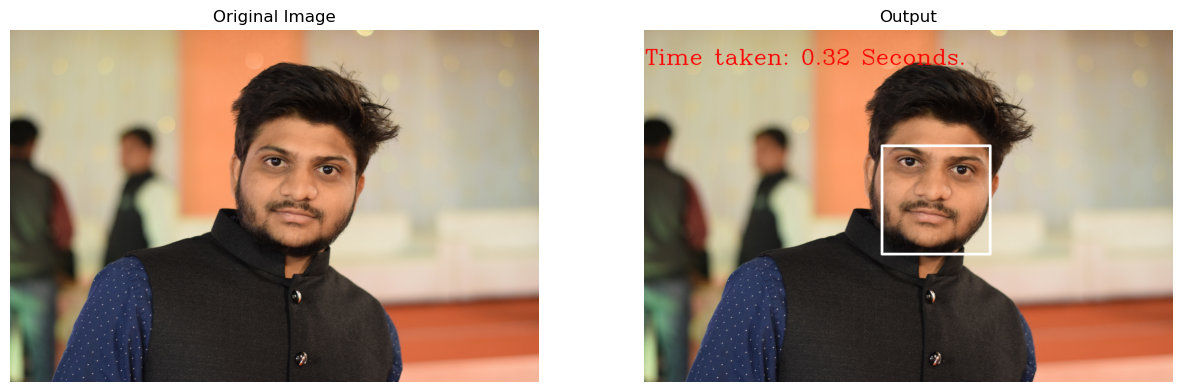

In [10]:
mp_detection(face_detection,sample_img)

# Compare face mesh (5 points) #

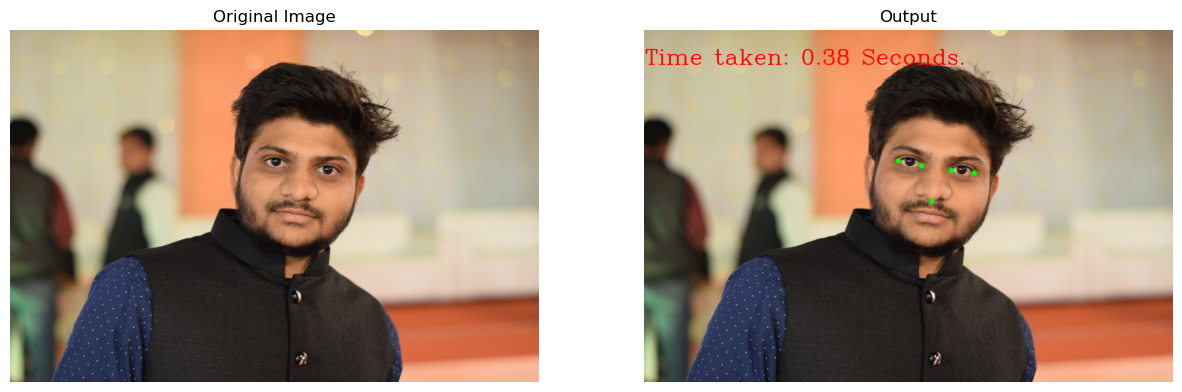

In [11]:
mp_landmark(face_mesh,sample_img,display=True)

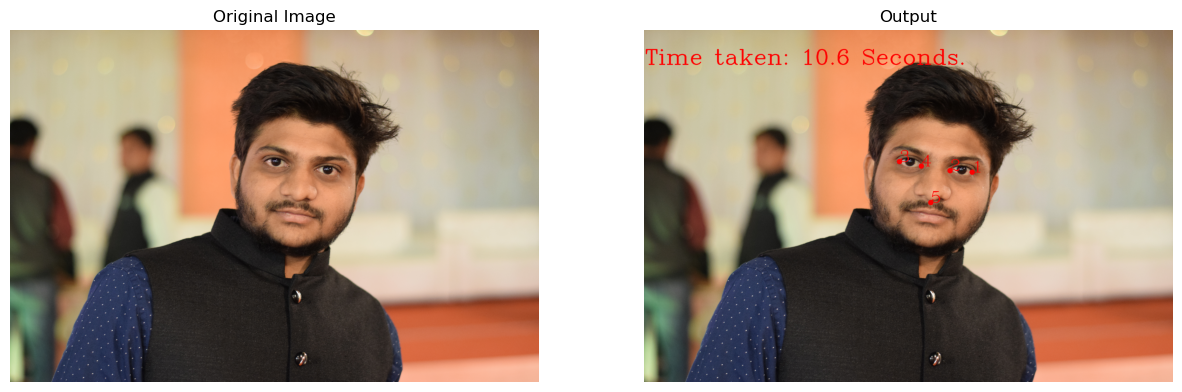

In [11]:
dlib_landmark(hog_face_detector,sample_img, display = True)

# comparing encoding dlib vs dlib+mp


In [22]:
##FULL MP

file1="Test\\test11.jpg".replace('\\' , '/')         ## control data
## calculating face distance using our hack algorithm

enc1=(ret_encoding(file1))
dist=[]
for i in range(6,14):
    file2="Test\\test"+str(i)+".jpg".replace('\\' , '/')
    enc2=(ret_encoding(file2))
    if (enc1 is not None) and (enc2 is not None):
        print(file2)
        enc1=np.array(enc1)
        enc2=np.array(enc2)
        d=np.linalg.norm(enc1 - enc2, axis=0)
        print(d)
        dist.append(d)
        

Test\test6.jpg
0.7395310918605329
Test\test7.jpg
0.626691619127576
Test\test8.jpg
0.6001298955149549
Test\test9.jpg
0.6436597990522174
Test\test10.jpg
0.5758041930746444
Test\test11.jpg
0.0
Test\test12.jpg
0.5726047689335825
Test\test13.jpg
0.7427886863451166


In [24]:
# DLIB detection and MP landmark

file1="Test\\test11.jpg".replace('\\' , '/')         ## control data
## calculating face distance using our hack algorithm

enc1=(ret_encoding(file1))
dist=[]
for i in range(6,14):
    file2="Test\\test"+str(i)+".jpg".replace('\\' , '/')
    enc2=(ret_encoding(file2))
    if (enc1 is not None) and (enc2 is not None):
        print(file2)
        enc1=np.array(enc1)
        enc2=np.array(enc2)
        d=np.linalg.norm(enc1 - enc2, axis=0)
        print(d)
        dist.append(d)
        

Test\test6.jpg
0.7395310918605329
Test\test7.jpg
0.626691619127576
Test\test8.jpg
0.6001298955149549
Test\test9.jpg
0.6436597990522174
Test\test10.jpg
0.5758041930746444
Test\test11.jpg
0.0
Test\test12.jpg
0.5726047689335825
Test\test13.jpg
0.7427886863451166


In [14]:
##FULL DLIB

file1="Test\\test11.jpg".replace('\\' , '/')

#calculating face distance using dlib

enc1=face_recognition.face_encodings( face_recognition.load_image_file(file1))[0]
dist=[]
for i in range(6,14):
    file2="Test\\test"+str(i)+".jpg".replace('\\' , '/')
    enc2=face_recognition.face_encodings( face_recognition.load_image_file(file2))
    if (enc1 is not None) and (enc2 is not None) :
        if not len(enc2)==0:
            #print(enc2)
            enc2=enc2[0]
            print(file2)
            d=face_recognition.face_distance([enc1], enc2)
            print(d)
            dist.append(d)

Test\test6.jpg
[0.78137385]
Test\test7.jpg
[0.65486002]
Test\test8.jpg
[0.60346292]
Test\test10.jpg
[0.65985804]
Test\test11.jpg
[0.]
Test\test12.jpg
[0.28092674]
Test\test13.jpg
[0.67783402]


# dataframe creation

In [15]:
folder="C:\\Users\\jhash\\Pictures\\images forward"
csv_name="face_encodings.csv"
col1="file_name"
col2="encoding"

In [16]:
# encodings column list for splitting
col_list=[]
for i in range(128):
    col_list.append(col2+str(i))
#col_list

In [17]:
curr=0
#initializing the dataframe
image_data=pd.DataFrame(columns=[col1, col2])
#going through the whole folder
for subdir, dirs, files in os.walk(folder):
    total = len(files)
    for file in files:
        if curr%10==0:print(curr,"/",total)
        curr+=1
        filepath = os.path.join(subdir, file)        
        filepath=filepath.replace('\\' , '/')  ## cv2 accepts files with "/" instead of "\"
        encodings=ret_encoding(filepath)
        if encodings is not None:              ## checking if a face is found
            data=pd.DataFrame({col1:file,col2:[np.array(encodings)]})
            image_data = pd.concat([image_data,data],ignore_index=True)   

#splitting the encodings column
output_data = pd.DataFrame(image_data[col2].to_list(), columns=col_list)
#adding the filename column and then puting it first
output_data[[col1]]=pd.DataFrame(image_data[col1].tolist(),index=image_data.index)
clms = output_data.columns.tolist()
clms = clms[-1:] + clms[:-1]
output_data=output_data[clms]
# saving without index
output_data.to_csv(csv_name, index=False)
df = pd.read_csv(csv_name)
df.tail()

0 / 257
10 / 257
20 / 257
30 / 257
40 / 257
50 / 257
60 / 257
70 / 257
80 / 257
90 / 257
100 / 257
110 / 257
120 / 257
130 / 257
140 / 257
150 / 257
160 / 257
170 / 257
180 / 257
190 / 257
200 / 257
210 / 257
220 / 257
230 / 257
240 / 257
250 / 257


,file_name,encoding0,encoding1,encoding2,encoding3,encoding4,encoding5,encoding6,encoding7,encoding8,...,encoding118,encoding119,encoding120,encoding121,encoding122,encoding123,encoding124,encoding125,encoding126,encoding127
251,faceimg_crop1_X-20toX1_Y-4toY4_Z-3toZ3_maxResi...,-0.079807,0.137509,0.089129,-0.092890,-0.105132,-0.009044,-0.033533,-0.032412,0.075336,...,0.145248,0.112138,-0.012480,-0.029075,-0.125402,-0.065610,0.005909,0.009324,0.035681,0.025334
252,faceimg_crop1_X-20toX1_Y-4toY4_Z-3toZ3_maxResi...,-0.055782,0.125578,0.072514,0.000065,-0.084224,0.020227,-0.078825,-0.048576,0.078979,...,0.111807,0.127101,0.019371,-0.033960,-0.212995,-0.051958,0.059104,-0.051903,-0.014109,0.008673
253,faceimg_crop1_X-20toX1_Y-4toY4_Z-3toZ3_maxResi...,-0.086421,0.109067,0.045466,0.014153,-0.042379,-0.066649,0.053704,-0.030020,0.132115,...,0.035348,0.086809,-0.035150,0.011970,-0.112842,-0.043067,0.035745,-0.004792,0.006708,0.007947
254,faceimg_crop1_X-20toX1_Y-4toY4_Z-3toZ3_maxResi...,-0.070443,0.136848,0.090088,-0.034978,-0.074073,-0.003007,-0.039840,-0.038407,0.064756,...,0.074657,0.171275,-0.009161,-0.014170,-0.183927,-0.089004,0.003948,-0.045775,-0.022274,0.030438
255,faceimg_crop1_X-20toX1_Y-4toY4_Z-3toZ3_maxResi...,-0.065118,0.151053,0.094751,-0.036597,-0.047058,-0.005689,-0.046844,-0.025361,0.108455,...,0.117132,0.096561,0.001850,-0.066637,-0.147122,-0.070799,0.025561,-0.046549,0.006364,-0.012201
